# Analysing new action results. 

Three groups:
1. actions -> group of 60/100 who received the intervention, need to be merged with the 40 who didn't from prev results (random method of selection: no selection bias)
2. counterfactual -> group of 100 who all receive the no-intervention promps, but 60 were intervened on -> same group as actions
3. control -> group of 100 who in real life did not get the intervention, and in sim get the no-intervention prompts

- box plots to compare distrbutions between engaged and not engaged mothers
- plot engagement over time 
- state transition heatmap 
- engagement probability before and after intervention 
- effect of interventions by feature: Stratify results by features (e.g., age, income, education) to see which groups benefit most from intervention

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from analysis.aggregation import *
from analysis.plot import *
from analysis.normalization import *
from analysis.utils import *
from models.preprocess import *

In [17]:
figsize = (13, 5)
tfs = 16
lfs = 14

### Analyse true trajectories 
Need both sets: random and control

In [3]:
data_path = 'data/trajectories_continuous.json'
num_full_sample = 500 
num_arms = 100
new_preds = 60

In [49]:
# Random group (w intervention)

y_features, y_state_trajectories, y_action_trajectories = data_preprocessing(data_path)

y_features = y_features[:num_full_sample]
y_features_array = np.array(y_features)

y_state_trajectories = y_state_trajectories[:num_full_sample]
y_state_trajectories = [[1 if time > 30 else 0 for time in arm] for arm in y_state_trajectories]

y_action_trajectories = y_action_trajectories[:num_full_sample]
act_on = [i for i, arm in enumerate(y_action_trajectories) if any(arm)] # indices of arms that have been acted on

Group random: Avg pulls = 0.015


In [50]:
# Control group (no intervention)

n_features, n_state_trajectories, n_action_trajectories = data_preprocessing(data_path, groups=['control'])

n_features = n_features[:num_full_sample]
n_features_array = np.array(n_features)

n_state_trajectories = n_state_trajectories[:num_full_sample]
n_state_trajectories = [[1 if time > 30 else 0 for time in arm] for arm in n_state_trajectories]

n_action_trajectories = n_action_trajectories[:num_full_sample]

Group control: Avg pulls = 0.0


## Sort out action space

for intervention and non-intervention cases

In [51]:
# subset of states and actions for the mothers who were intervened on
acted_states = [y_state_trajectories[i] for i in act_on]
acted_actions = [y_action_trajectories[i] for i in act_on]

# percentage of mothers acted on in each time step (all actions in first 6 time steps)
counts = [sum(timestep) for timestep in zip(*acted_actions)]
k = np.mean(counts[:6])/num_full_sample

# get representative subset of num_arms (num acted on) mothers: k-means clustering with num_arms clusters
y_selected_indices = select_representative_mothers(y_features_array, y_state_trajectories, num_arms)

y_representative_features = [y_features[i] for i in y_selected_indices]
y_representative_states = [y_state_trajectories[i] for i in y_selected_indices]
y_representative_actions = [y_action_trajectories[i] for i in y_selected_indices]

# subset of actions for the mothers who were intervened on
y_representative_act_on = [i for i, arm in enumerate(y_representative_actions) if any(arm)]
len(y_representative_act_on) # number of mothers acted on in the representative subset (approx 60%)


Selected mothers engagement stats:
Full trajectory statistics:
Mean engagement: 0.552 (±0.332)
Mean variance: 0.137 (±0.084)
Mean trend: -0.009 (±0.011)


59

In [52]:
## no intervention 

# get representative subset of num_arms mothers: k-means clustering with num_arms clusters
n_selected_indices = select_representative_mothers(n_features_array, n_state_trajectories, num_arms)

n_representative_features = [n_features[i] for i in n_selected_indices]
n_representative_states = [n_state_trajectories[i] for i in n_selected_indices]
n_representative_actions = [n_action_trajectories[i] for i in n_selected_indices]


Selected mothers engagement stats:
Full trajectory statistics:
Mean engagement: 0.508 (±0.341)
Mean variance: 0.134 (±0.089)
Mean trend: -0.009 (±0.011)


## Get predicted trajectories

In [59]:
models = ["google", "openai", "openaiheavy", "anthropic"] #"googlepro",
labels = ["Gemini Flash", "Gemini Pro", "GPT-4o mini", "GPT-4o", "Claude Instant"]

cmap = matplotlib.colormaps['Paired']
colors = [cmap(i) for i in range(12)]
colors = [colors[i] for i in [0,1,2,3,7]]
ens_colors = ['#DC143C', 'k', 'gray']
titles = ['Google', 'OpenAI', 'Anthropic']

t1, t2, long_t2 = 0, 15, 40

normalization_function = rank_normalization

##### Define actions

Need to create full set of actions for the 60 new arms, and add actions of all 0s for the rest of the 40 unacted arms (in this new subsest of 100 mothers)

In [54]:
# df of all actions on the 60% of mothers acted on for all 40 timesteps --> need to select first t2 cols (+1 for index)
new_actions_df = pd.read_csv(f'results/actions/action_trajectories_{new_preds}_t1_{t1}_t2_{t2}.csv')
new_actions_df = new_actions_df.iloc[:, :t2+1]
new_actions_df.head()

,Mother Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
idx_preds = new_actions_df['Mother Index'].to_list() # indices of predicted arms in the 100
idx_preds_full = [y_selected_indices[i] for i in idx_preds] # indices of predicted arms in the 500 # new idx

not_pred = [i for i in range(num_arms) if i not in idx_preds] # arms that were not predicted in the 100
not_pred_full = [y_selected_indices[i] for i in not_pred] # indices of not predicted arms in the 500 # old idx

append with 0s for all the old action trajectories

In [56]:
actions_to_add = pd.DataFrame({
    "Mother Index": not_pred,
    **{col: 0 for col in new_actions_df.columns if col != "Mother Index"}
})
df_all_actions = pd.concat([new_actions_df, actions_to_add], ignore_index=True)
df_all_actions = df_all_actions.set_index('Mother Index').sort_index()
df_all_actions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Mother Index,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get Predictions

In [57]:
# Dictionary to store results for each model
model_results = {
    model: {
        "predictions": [f"results/actions/{model}_{num_arms}/all_individual_predictions_t1_{t1}_t2_{t2}.json"],
        "predictions_old": [f"results/weekly/{model}_{num_full_sample}/all_individual_predictions_t1_{t1}_t2_{long_t2}.json"],
        "ground_truths": [f"results/actions/{model}_{num_arms}/ground_truths_t1_{t1}_t2_{t2}_week_{t2-1}.json"],
        "ground_truths_old": [f"results/weekly/{model}_{num_full_sample}/ground_truths_t1_{t1}_t2_{long_t2}_week_{long_t2-1}.json"],
        "y_epistemic_uncertainty": [],
        "y_mean_predictions": [],
        "n_epistemic_uncertainty": [],
        "n_mean_predictions": []
    } for model in models
}

In [60]:
for model in models:
    model_data = model_results[model] # dict for this model

    # Load predictions and ground truths for new intervened set of arms
    # all_individual_preds : all 25 predictions for each arm and timestep [[],[],[],[],[]]
    new_individual_preds, new_ground_truths = load_predictions_and_ground_truths(
        model_data["predictions"][0], model_data["ground_truths"][0]
    )

    # print(len(new_individual_preds), len(new_individual_preds[0]), len(new_individual_preds[0][0]))
    
    new_individual_preds = np.reshape(new_individual_preds, (t2-t1, new_preds, 5, 5))
    new_ground_truths = np.squeeze(new_ground_truths)

    # now for each model, we need to read in the predictions for the 40 missing arms (from main 500 predictions)
    old_individual_preds_all, old_ground_truths = load_predictions_and_ground_truths(
        model_data["predictions_old"][0], model_data["ground_truths_old"][0]
    )
    old_individual_preds_all = np.reshape(old_individual_preds_all, (long_t2-t1, num_full_sample, 5, 5))

    # no_intervention predictions for the group who were not acted on
    old_individual_preds = old_individual_preds_all[t1:t2, not_pred_full, :, :]
    # no_intervention predictions for the group who were acted on
    no_intervention_preds = old_individual_preds_all[t1:t2, idx_preds_full, :, :]

    # old_ground_truths : 40 x 500
    old_ground_truths = np.squeeze(old_ground_truths)
    old_ground_truths = old_ground_truths[t1:t2, not_pred_full] # --> NO ACTIONS

    print('\nMODEL: ', model)
    print("Shape before concatenation:")
    print("new_individual_preds:", new_individual_preds.shape)
    print("old_individual_preds:", old_individual_preds.shape)
    print("no_intervention_preds:", no_intervention_preds.shape)

    print("\nSample means before processing:")
    print("new_individual_preds mean:", np.mean(new_individual_preds))
    print("old_individual_preds mean:", np.mean(old_individual_preds))
    print("no_intervention_preds mean:", np.mean(no_intervention_preds))

    # want a set of predictions and related actions for 2 groups : with intervention, without intervention
    # we have the predictions --> need to merge old_individual_preds w new_individual_preds
    all_individual_preds = np.concatenate((new_individual_preds, old_individual_preds), axis=1)
    no_intervention_preds = np.concatenate((no_intervention_preds, old_individual_preds), axis=1)
    all_ground_truths = np.concatenate((new_ground_truths, old_ground_truths), axis=1)

    # Loop over timesteps and arms, get actual final predictions for each in both scenarios
    y_final_preds_all_time, n_final_preds_all_time = [], []
    for t in range(t2-t1):
        y_final_preds_all_arms, n_final_preds_all_arms = [], []

        for arm in range(num_arms):
            y_prompts_runs = all_individual_preds[t][arm] # 5 * 5
            n_prompts_runs = no_intervention_preds[t][arm] # 5 * 5

            y_mean_predictions_per_prompt = np.mean(y_prompts_runs, axis=1)
            n_mean_predictions_per_prompt = np.mean(n_prompts_runs, axis=1) 

            y_final_mean_prediction = np.mean(y_mean_predictions_per_prompt) 
            n_final_mean_prediction = np.mean(n_mean_predictions_per_prompt) 

            y_final_preds_all_arms.append(y_final_mean_prediction)
            n_final_preds_all_arms.append(n_final_mean_prediction)

        y_final_preds_all_time.append(y_final_preds_all_arms)
        n_final_preds_all_time.append(n_final_preds_all_arms)

    # Calculate uncertainties for y case (intervention)
    timestep_ind_preds = restructure_predictions(all_individual_preds)
    for time_mat in timestep_ind_preds:
        epistemic_uncertainty, _, _ = compute_uncertainties_from_llm_predictions(time_mat) 
        epistemic_uncertainty = np.squeeze(epistemic_uncertainty)
        model_data["y_epistemic_uncertainty"].append(epistemic_uncertainty)
    
    # Calculate uncertainties for n case (no intervention)
    n_timestep_ind_preds = restructure_predictions(no_intervention_preds)
    for time_mat in n_timestep_ind_preds:
        epistemic_uncertainty, _, _ = compute_uncertainties_from_llm_predictions(time_mat) 
        epistemic_uncertainty = np.squeeze(epistemic_uncertainty)
        model_data["n_epistemic_uncertainty"].append(epistemic_uncertainty)

    # Loop over timesteps for mean prediction calculation
    for t in range(t2-t1):  
        y_preds_at_t = [y_final_preds_all_time[t][arm] for arm in range(num_arms)]  
        model_data["y_mean_predictions"].append(y_preds_at_t)
        
        n_preds_at_t = [n_final_preds_all_time[t][arm] for arm in range(num_arms)]  
        model_data["n_mean_predictions"].append(n_preds_at_t)

y_results_for_aggregation, n_results_for_aggregation = {}, {}
y_uncertainties_for_aggregation, n_uncertainties_for_aggregation = {}, {}
for model in models:
    for i, (result, uncertainty) in enumerate(zip(model_results[model]["y_mean_predictions"], model_results[model]["y_epistemic_uncertainty"])):
        y_results_for_aggregation.setdefault(i, []).append(result)
        y_uncertainties_for_aggregation.setdefault(i, []).append(uncertainty)
    
    for i, (result, uncertainty) in enumerate(zip(model_results[model]["n_mean_predictions"], model_results[model]["n_epistemic_uncertainty"])):
        n_results_for_aggregation.setdefault(i, []).append(result)
        n_uncertainties_for_aggregation.setdefault(i, []).append(uncertainty)

yP_combined, yP_direct_avg, yP_lowest_unc = [], [], []
nP_combined, nP_direct_avg, nP_lowest_unc = [], [], []
for t in range(t2-t1):

    # y case (intervention)
    combined = bayesian_aggregation(predictions=y_results_for_aggregation[t],
                                    uncertainties=y_uncertainties_for_aggregation[t],
                                    normalization_method=normalization_function)
    yP_combined.append(combined)
    
    direct_avg = direct_averaging(predictions=y_results_for_aggregation[t])
    yP_direct_avg.append(direct_avg)

    lowest_unc = uncertainty_based_selection(predictions=y_results_for_aggregation[t],
                                                uncertainties=y_uncertainties_for_aggregation[t],
                                                normalization_method=normalization_function)
    yP_lowest_unc.append(lowest_unc)

    # n case (no intervention)
    n_combined = bayesian_aggregation(predictions=n_results_for_aggregation[t],
                                    uncertainties=n_uncertainties_for_aggregation[t],
                                    normalization_method=normalization_function)
    nP_combined.append(n_combined)

    n_direct_avg = direct_averaging(predictions=n_results_for_aggregation[t])
    nP_direct_avg.append(n_direct_avg)

    n_lowest_unc = uncertainty_based_selection(predictions=n_results_for_aggregation[t],
                                                uncertainties=n_uncertainties_for_aggregation[t],
                                                normalization_method=normalization_function)
    nP_lowest_unc.append(n_lowest_unc)


MODEL:  google
Shape before concatenation:
new_individual_preds: (15, 60, 5, 5)
old_individual_preds: (15, 40, 5, 5)
no_intervention_preds: (15, 60, 5, 5)

Sample means before processing:
new_individual_preds mean: 0.6644888888888889
old_individual_preds mean: 0.6618666666666667
no_intervention_preds mean: 0.7140888888888889

MODEL:  openai
Shape before concatenation:
new_individual_preds: (15, 60, 5, 5)
old_individual_preds: (15, 40, 5, 5)
no_intervention_preds: (15, 60, 5, 5)

Sample means before processing:
new_individual_preds mean: 0.7168444444444444
old_individual_preds mean: 0.7325333333333334
no_intervention_preds mean: 0.7782666666666667

MODEL:  openaiheavy
Shape before concatenation:
new_individual_preds: (15, 60, 5, 5)
old_individual_preds: (15, 40, 5, 5)
no_intervention_preds: (15, 60, 5, 5)

Sample means before processing:
new_individual_preds mean: 0.7495111111111111
old_individual_preds mean: 0.8048
no_intervention_preds mean: 0.8651111111111112

MODEL:  anthropic
Shap

In [14]:
ensemble_results = {}

ensemble_results["aggregated"] = {
    "y_mean_predictions": yP_combined,
    "n_mean_predictions": nP_combined
} 
ensemble_results["averaged"] = {
    "y_mean_predictions": yP_direct_avg,
    "n_mean_predictions": nP_direct_avg
} 
ensemble_results["lowest_unc"] = {
    "y_mean_predictions": yP_lowest_unc,
    "n_mean_predictions": nP_lowest_unc
} 

ensemble_models = (["aggregated", "averaged", "lowest_unc"])
ensemble_labels = (["Aggregated", "Averaged", "Lowest Uncertainty"])

Now, `model_results[model]["mean_predictions"]` contains (time steps) lists each of len = 100 with the relevant mean predictions for that arm at that time step for all models, including the ensembling models. 

Actions are contained in df_all_actions.

#### plot engagement over time

In [15]:
# mean engagement per week for ground truths

## intervention
y_gcs = [arm[:t2] for arm in y_representative_states]
y_gcs = np.array(y_gcs)  # (num_mothers, num_weeks)
y_true_engagement_over_time = np.mean(y_gcs, axis=0) 

## no intervention
n_gcs = [arm[:t2] for arm in n_representative_states]
n_gcs = np.array(n_gcs)
n_true_engagement_over_time = np.mean(n_gcs, axis=0) 

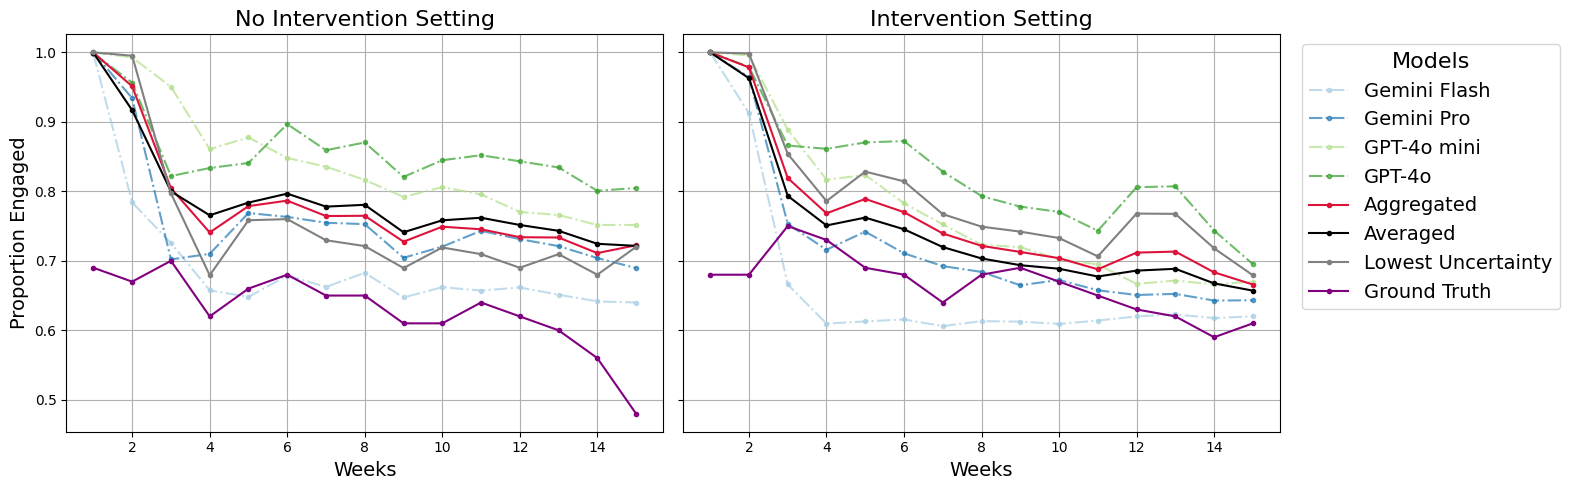

In [18]:
# Plot engagement over time
fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=True)

# Plot predictions for each model
for i, model in enumerate(models):
    # mean engagement per week
    y_model_predictions = np.array(model_results[model]["y_mean_predictions"])  # (num_time_steps, num_mothers)
    y_mean_engagement_predictions = np.mean(y_model_predictions, axis=1)  # avg  over all mothers
    n_model_predictions = np.array(model_results[model]["n_mean_predictions"])  
    n_mean_engagement_predictions = np.mean(n_model_predictions, axis=1) 
    
    axs[1].plot(range(1, len(y_mean_engagement_predictions) + 1), y_mean_engagement_predictions, 
                marker="o", color=colors[i], linestyle="-.", markersize=3, label=labels[i], alpha=0.7)
    axs[0].plot(range(1, len(n_mean_engagement_predictions) + 1), n_mean_engagement_predictions, 
                marker="o", color=colors[i], linestyle="-.", markersize=3, label=labels[i], alpha=0.7)
    
# Plot ensemble predictions
for i, ensemble in enumerate(ensemble_models):
    y_ensemble_predictions = ensemble_results[ensemble]["y_mean_predictions"]
    y_mean_engagement_predictions = np.mean(y_ensemble_predictions, axis=1)
    ensemble_results[ensemble]['y_mean_engagement_predictions'] = y_mean_engagement_predictions
    n_ensemble_predictions = ensemble_results[ensemble]["n_mean_predictions"]
    n_mean_engagement_predictions = np.mean(n_ensemble_predictions, axis=1) 
    ensemble_results[ensemble]['n_mean_engagement_predictions'] = n_mean_engagement_predictions

    axs[1].plot(range(1, len(y_mean_engagement_predictions) + 1), y_mean_engagement_predictions, 
                marker="o", linestyle="-", markersize=3, color=ens_colors[i], label=ensemble_labels[i])
    axs[0].plot(range(1, len(n_mean_engagement_predictions) + 1), n_mean_engagement_predictions, 
                marker="o", linestyle="-", markersize=3, color=ens_colors[i], label=ensemble_labels[i])

# Plot Ground Truth Engagement
axs[0].plot(range(1, len(n_true_engagement_over_time) + 1), n_true_engagement_over_time, 
            marker="o", markersize=3, linestyle="-", color="purple", label="Ground Truth")
axs[1].plot(range(1, len(y_true_engagement_over_time) + 1), y_true_engagement_over_time, 
            marker="o", markersize=3, linestyle="-", color="purple", label="Ground Truth")

axs[1].set_title("Intervention Setting", fontsize=tfs)
axs[0].set_title("No Intervention Setting", fontsize=tfs)

axs[1].set_xlabel("Weeks", fontsize=lfs)
axs[0].set_xlabel("Weeks", fontsize=lfs)
axs[0].set_ylabel("Proportion Engaged", fontsize=lfs)

axs[0].grid(True)
axs[1].grid(True)

plt.tight_layout()
plt.legend(fontsize=lfs, bbox_to_anchor=(1.02, 1), loc='upper left', title="Models", title_fontsize=tfs)
plt.show()

## Difference in Engagement

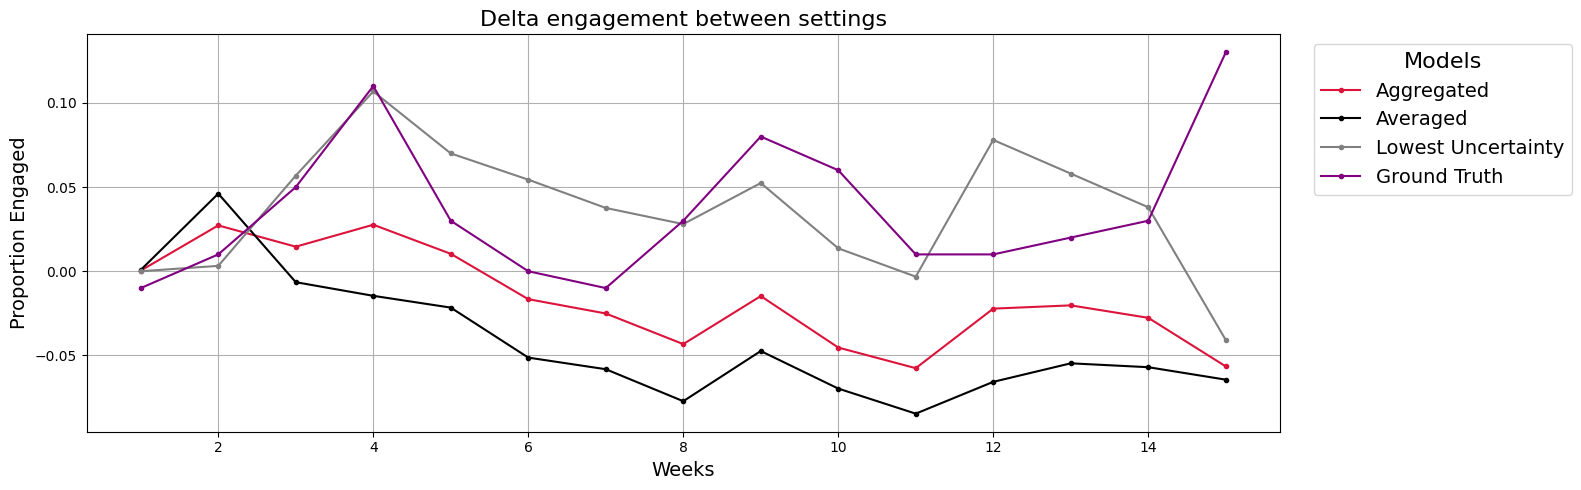

In [19]:
# Plot difference in engagement between intervention and no intervention for gcs and ensemble models 
plt.figure(figsize=figsize)

for i, ensemble in enumerate(ensemble_models):
    diff = ensemble_results[ensemble]['y_mean_engagement_predictions'] - ensemble_results[ensemble]['n_mean_engagement_predictions']
    plt.plot(range(1, len(diff) + 1), diff, 
            marker="o", linestyle="-", markersize=3, color=ens_colors[i], label=ensemble_labels[i])


# Plot Ground Truth DeltaEngagement
gc_diff = y_true_engagement_over_time - n_true_engagement_over_time
plt.plot(range(1, len(gc_diff) + 1), gc_diff, 
        marker="o", markersize=3, linestyle="-", color="purple", label="Ground Truth")

plt.title("Delta engagement between settings", fontsize=tfs)
plt.xlabel("Weeks", fontsize=lfs)
plt.ylabel("Proportion Engaged", fontsize=lfs)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=lfs, bbox_to_anchor=(1.02, 1), loc='upper left', title="Models", title_fontsize=tfs)
plt.show()

#### transition heatmaps

##### for ground truth data

In [20]:
def get_transitions_over_time(test_states):
    test_states = np.array(test_states)
        
    weeks, arms = test_states.shape
    
    transitions = np.zeros((weeks - 1, 2, 2), dtype=int)
    counts = np.zeros((weeks - 1, 2), dtype=int)

    # Count transitions
    for t in range(weeks - 1):
        for a in range(arms):
            from_state = int(np.round(test_states[t, a]))
            to_state = int(np.round(test_states[t + 1, a]))
            transitions[t, from_state, to_state] += 1
            counts[t, from_state] += 1
    
    # Calculate probabilities
    probabilities = np.zeros((weeks - 1, 2, 2), dtype=float)
    for t in range(weeks - 1):
        for s in (0, 1):
            if counts[t, s] > 0:
                # Divide each transition by count for that state
                probabilities[t, s, :] = transitions[t, s, :] / counts[t, s]
    
    return probabilities

In [21]:
def probs_to_plot(probs, t2):

    weeks = range(t2-1)

    # Extract each of the 4 probabilities 
    p00 = [probs[w][0, 0] for w in weeks]  # 0->0
    p01 = [probs[w][0, 1] for w in weeks]  # 0->1
    p10 = [probs[w][1, 0] for w in weeks]  # 1->0
    p11 = [probs[w][1, 1] for w in weeks]  # 1->1

    return p00, p01, p10, p11

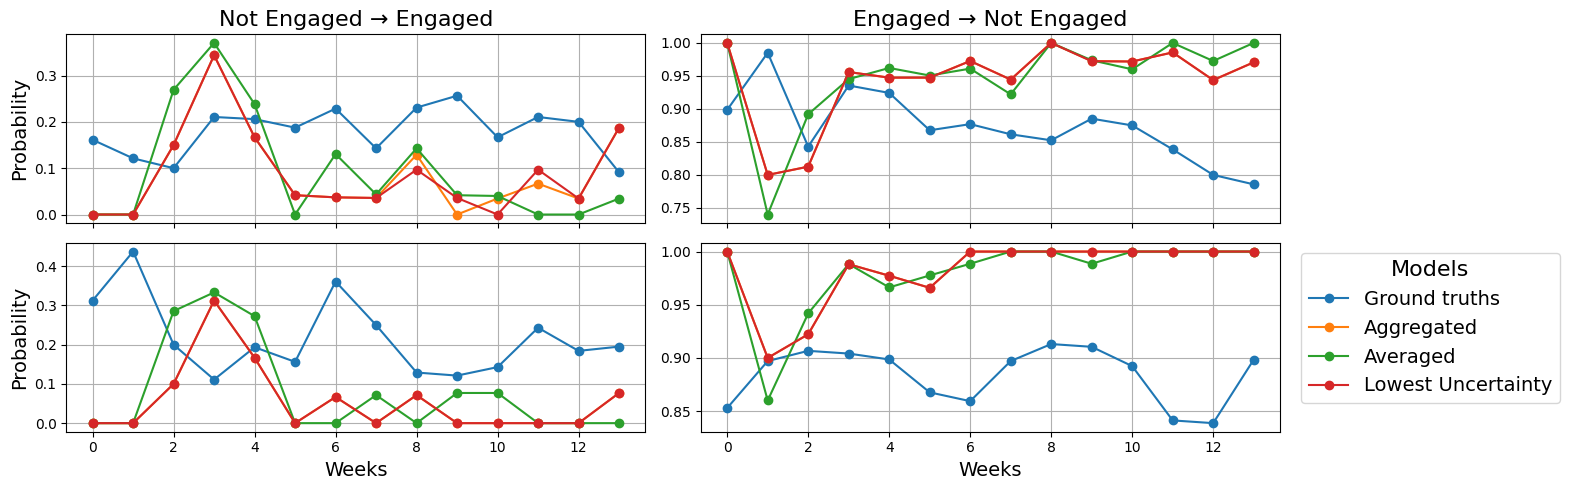

In [22]:
fig, axs = plt.subplots(2, 2, figsize=figsize, sharex=True)

axs[0, 0].set_title("Not Engaged → Engaged", fontsize=tfs)
axs[0, 1].set_title("Engaged → Not Engaged", fontsize=tfs)
axs[1, 0].set_xlabel("Weeks", fontsize=lfs)
axs[1, 1].set_xlabel("Weeks", fontsize=lfs)
axs[0, 0].set_ylabel("Probability", fontsize=lfs)
axs[1, 0].set_ylabel("Probability", fontsize=lfs)
    
weeks = range(t2-1)

# get prob values for each model and gcs

## gcs
p00, p01, p10, p11 = probs_to_plot(get_transitions_over_time(np.array(n_gcs).T), t2)
axs[0, 0].plot(weeks, p01, marker='o', label='Ground truths')
axs[0, 1].plot(weeks, p11, marker='o', label='Ground truths')

p00, p01, p10, p11 = probs_to_plot(get_transitions_over_time(np.array(y_gcs).T), t2)
axs[1, 0].plot(weeks, p01, marker='o', label='Ground truths')
axs[1, 1].plot(weeks, p11, marker='o', label='Ground truths')

# models
for ensemble in ensemble_models:
    p00, p01, p10, p11 = probs_to_plot(get_transitions_over_time(ensemble_results[ensemble]['n_mean_predictions']), t2)
    axs[0, 0].plot(weeks, p01, marker='o', label=f'{ensemble_labels[ensemble_models.index(ensemble)]}')
    axs[0, 1].plot(weeks, p11, marker='o', label=f'{ensemble_labels[ensemble_models.index(ensemble)]} no intervention')

    p00, p01, p10, p11 = probs_to_plot(get_transitions_over_time(ensemble_results[ensemble]['y_mean_predictions']), t2)
    axs[1, 0].plot(weeks, p01, marker='o', label=f'{ensemble_labels[ensemble_models.index(ensemble)]}')
    axs[1, 1].plot(weeks, p11, marker='o', label=f'{ensemble_labels[ensemble_models.index(ensemble)]}')
    
for ax in axs.flat:
    ax.grid(True)

plt.tight_layout()
plt.legend(fontsize=lfs, bbox_to_anchor=(1.02, 1), loc='upper left', title="Models", title_fontsize=tfs)
plt.show()

In [25]:
def compute_pre_post_transitions(df_all_actions, idx_preds, ensemble_results, model="aggregated"):
    """
    df_all_actions: DataFrame with rows = mothers, columns = weeks, containing 1 at the intervention week
    idx_preds: list of mother indices we want to process
    ensemble_results[model]["y_mean_predictions"]: (weeks x number_of_mothers) or something similar
                                                  we transpose/reshape to get the mother-specific time-series

    Returns:
       pre_intervention_probs: 2x2 matrix (average across all mothers' pre-intervention transitions)
       post_intervention_probs: dict of { offset: 2x2 matrix }, offset=0,1,2,... up to max available
    """

    pre_counts_trans = np.zeros((2, 2), dtype=int)  # cumulative transitions pre-intervention
    pre_counts_from = np.zeros(2, dtype=int)        # how many times we've come 'from' each state pre-intervention

    post_counts_trans = defaultdict(lambda: np.zeros((2, 2), dtype=int))  # transitions by offset
    post_counts_from = defaultdict(lambda: np.zeros(2, dtype=int))        # how many times we've come 'from' each state, by offset

    # Loop over each mother
    for mother_idx in idx_preds:
        row = df_all_actions.iloc[mother_idx]
        # Which column/week is intervention? (assumes exactly one '1' in the row)
        week = int(row[row == 1].index.tolist()[0])

        # Extract this mother’s full time series of states
        all_states = np.array(ensemble_results[model]["y_mean_predictions"])[:, mother_idx]

        # --- Pre-intervention transitions ---
        # from weeks 0..(week-2) to 1..(week-1)
        # e.g. if week=4, that covers transitions (0->1), (1->2), (2->3)
        for t in range(week - 1):
            f = int(round(all_states[t]))
            n = int(round(all_states[t + 1]))
            pre_counts_trans[f, n] += 1
            pre_counts_from[f] += 1

        # --- Post-intervention transitions ---
        # offset=0 means transition from (week-1 -> week)
        # offset=1 means transition from (week -> week+1), etc.
        # so if we have total_weeks = len(all_states),
        # the largest offset is (total_weeks - 1 - week - 1)
        total_weeks = len(all_states)
        max_offset = total_weeks - 1 - week  # last possible transition offset
        for offset in range(max_offset):
            f = int(round(all_states[week + offset]))
            n = int(round(all_states[week + offset + 1]))
            post_counts_trans[offset][f, n] += 1
            post_counts_from[offset][f] += 1

    # --- Convert counts to probabilities ---
    # Pre-intervention
    pre_intervention_probs = np.zeros((2, 2), dtype=float)
    for s in (0, 1):
        if pre_counts_from[s] > 0:
            pre_intervention_probs[s] = pre_counts_trans[s] / pre_counts_from[s]

    # Post-intervention by offset
    post_intervention_probs = {}
    for offset, mat in post_counts_trans.items():
        post_mat = np.zeros((2, 2), dtype=float)
        for s in (0, 1):
            if post_counts_from[offset][s] > 0:
                post_mat[s] = mat[s] / post_counts_from[offset][s]
        post_intervention_probs[offset] = post_mat

    return pre_intervention_probs, post_intervention_probs


def plot_post_intervention_probs(post_probs):
    """
    post_probs is a dict like { offset: 2x2 transition matrix }.
    We'll collect the four transitions for each offset and plot them.
    """
    offsets = sorted(post_probs.keys())
    
    # Extract each of the 4 probabilities at each offset
    p00 = [post_probs[o][0, 0] for o in offsets]  # 0->0
    p01 = [post_probs[o][0, 1] for o in offsets]  # 0->1
    p10 = [post_probs[o][1, 0] for o in offsets]  # 1->0
    p11 = [post_probs[o][1, 1] for o in offsets]  # 1->1
    
    plt.figure(figsize=figsize)
    # plt.plot(offsets, p00, marker='o', label='0→0')
    plt.plot(offsets, p01, marker='o', label='0→1')
    # plt.plot(offsets, p10, marker='o', label='1→0')
    plt.plot(offsets, p11, marker='o', label='1→1')
    
    plt.xlabel("Weeks Post Intervention")
    plt.ylabel("Transition Probability")
    plt.title("Post-Intervention Transition Probabilities Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# intervention 
pre_probs, post_probs = compute_pre_post_transitions(df_all_actions, idx_preds, ensemble_results, model="aggregated")
plot_post_intervention_probs(post_probs)

NameError: name 'defaultdict' is not defined

In [26]:
from collections import defaultdict
import numpy as np

def compute_pre_post_transitions(df_all_actions, idx_preds, ensemble_results, model="aggregated"):
    """
    Returns:
       pre_intervention_probs: 2x2 matrix (aggregate over all mothers pre-intervention)
       post_intervention_probs: dict { offset: 2x2 matrix } for each "weeks since intervention"
       post_mothers_count: dict { offset: #mothers contributing at this offset }
    """
    pre_counts_trans = np.zeros((2, 2), dtype=int)
    pre_counts_from  = np.zeros(2, dtype=int)

    post_counts_trans = defaultdict(lambda: np.zeros((2, 2), dtype=int))
    post_counts_from  = defaultdict(lambda: np.zeros(2, dtype=int))

    # Track which mothers contribute at each offset
    post_counts_mothers = defaultdict(set)

    for mother_idx in idx_preds:
        row  = df_all_actions.iloc[mother_idx]
        week = int(row[row == 1].index[0])  # the intervention week

        # Extract time series of predicted states
        all_states = np.array(ensemble_results[model]["y_mean_predictions"])[:, mother_idx]
        total_weeks = len(all_states)

        # --- Pre-intervention transitions ---
        # If the intervention is at 'week', then these transitions go up to (week - 1)
        for t in range(week - 1):
            f = int(round(all_states[t]))
            n = int(round(all_states[t + 1]))
            pre_counts_trans[f, n] += 1
            pre_counts_from[f]     += 1

        # --- Post-intervention transitions ---
        max_offset = (total_weeks - 1) - week
        for offset in range(max_offset):
            f = int(round(all_states[week + offset]))
            n = int(round(all_states[week + offset + 1]))
            post_counts_trans[offset][f, n] += 1
            post_counts_from[offset][f]     += 1

            # Mark that this mother contributed a transition at this offset
            post_counts_mothers[offset].add(mother_idx)

    # Convert counts to probabilities
    pre_intervention_probs = np.zeros((2, 2), dtype=float)
    for s in (0, 1):
        if pre_counts_from[s] > 0:
            pre_intervention_probs[s] = pre_counts_trans[s] / pre_counts_from[s]

    post_intervention_probs = {}
    for offset, mat in post_counts_trans.items():
        post_mat = np.zeros((2, 2), dtype=float)
        for s in (0, 1):
            denom = post_counts_from[offset][s]
            if denom > 0:
                post_mat[s] = mat[s] / denom
        post_intervention_probs[offset] = post_mat

    # Convert set-of-mothers to a count of mothers
    post_mothers_count = {offset: len(mother_set) for offset, mother_set in post_counts_mothers.items()}

    return pre_intervention_probs, post_intervention_probs, post_mothers_count, post_counts_from



def plot_post_intervention_probs(post_probs, post_mothers_count, figsize=(8,6)):
    """
    post_probs: dict { offset: 2x2 matrix }
    post_mothers_count: dict { offset: number_of_mothers_contributing }

    We plot 0->1 and 1->1 over offset, then overlay mother counts on a second axis.
    """
    offsets = sorted(post_probs.keys())

    # Extract the probabilities for transitions of interest
    p01 = [post_probs[o][0, 1] for o in offsets]  # 0->1
    p11 = [post_probs[o][1, 1] for o in offsets]  # 1->1

    plt.figure(figsize=figsize)
    ax1 = plt.gca()

    ax1.plot(offsets, p01, marker='o', label='0→1')
    ax1.plot(offsets, p11, marker='o', label='1→1')
    ax1.set_xlabel("Weeks Post Intervention")
    ax1.set_ylabel("Transition Probability")
    ax1.set_title("Post-Intervention Transition Probabilities Over Time")
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Plot #mothers on a second y-axis
    ax2 = ax1.twinx()
    mother_counts = [post_mothers_count[o] for o in offsets]
    ax2.plot(offsets, mother_counts, 'r--', markersize=3, label='#Mothers')
    ax2.set_ylabel("Number of Mothers Contributing")

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.show()

In [27]:
# intervention 
pre_intervention_probs, post_intervention_probs, post_mothers_count, post_counts_from = compute_pre_post_transitions(df_all_actions, idx_preds, ensemble_results, model="aggregated")
plot_post_intervention_probs(post_probs, post_mothers_count)

NameError: name 'post_probs' is not defined

In [28]:
pre_intervention_probs, post_intervention_probs

(array([[1.        , 0.        ],
        [0.03092784, 0.96907216]]),
 {0: array([[0.6       , 0.4       ],
         [0.01818182, 0.98181818]]),
  1: array([[0.75, 0.25],
         [0.  , 1.  ]]),
  2: array([[1.        , 0.        ],
         [0.05263158, 0.94736842]]),
  3: array([[0.83333333, 0.16666667],
         [0.        , 1.        ]]),
  4: array([[0.8, 0.2],
         [0. , 1. ]]),
  5: array([[1.        , 0.        ],
         [0.03571429, 0.96428571]]),
  6: array([[1., 0.],
         [0., 1.]]),
  7: array([[1., 0.],
         [0., 1.]]),
  8: array([[1., 0.],
         [0., 1.]]),
  9: array([[1., 0.],
         [0., 1.]]),
  10: array([[1., 0.],
         [0., 1.]]),
  11: array([[1., 0.],
         [0., 1.]]),
  12: array([[1., 0.],
         [0., 1.]]),
  13: array([[1., 0.],
         [0., 1.]])})

In [29]:
post_mothers_count

{0: 60,
 1: 60,
 2: 60,
 3: 60,
 4: 60,
 5: 60,
 6: 60,
 7: 60,
 8: 60,
 9: 50,
 10: 40,
 11: 30,
 12: 20,
 13: 10}

In [30]:
# this already gives us lists over time for the no_intervention case, the control case, and for both gcs. Can plot this for all models. 
# now need to look at the intervention case i.e those who actuaky receive the intervention.

# idx_preds # indices of intervened arms in the 100
# not_pred  # arms that were not predicted in the 100

model = "aggregated"

for mother_idx in idx_preds:
    # Find columns where value is 1
    row = df_all_actions.iloc[mother_idx]
    week = int(row[row == 1].index.tolist()[0])

    states = np.array(ensemble_results[model]["y_mean_predictions"]).T[0]

    if week != 0:
        # split trajectory into pre and post intervention
        pre_intervention = states[:week]
        post_intervention = states[week:]

In [31]:
print(df_all_actions.iloc[0])

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
Name: 0, dtype: float64


In [32]:
def get_intervention_transitions(n_states, y_states, action_df):
    """
    Calculate transition probabilities between states, split by intervention status
    
    Parameters:
    states: numpy array of shape (n_weeks, n_mothers) containing state sequences
    action_df: DataFrame with 'Mother Index' and week columns (0-N) containing intervention indicators
    """
    
    # transpose states to be (n_mothers, n_weeks)
    n_states = n_states.T
    y_states = y_states.T
    
    # Create set of mothers who received intervention
    treatment_indices = df_all_actions.index[df_all_actions.eq(1).any(axis=1)].tolist()
    
    # Split into intervention/no intervention groups
    control_indices = np.array([i for i in range(y_states.shape[0]) if i not in treatment_indices])
    treatment_indices = np.array(treatment_indices)
    
    weeks = y_states.shape[1]
    control_states = y_states[control_indices]
    
    # Calculate control group transitions
    for mother_idx in range(control_states.shape[0]):
        for week in range(weeks - 1):
            prev_state = int(round(control_states[mother_idx, week]))
            next_state = int(round(control_states[mother_idx, week + 1]))
            control_transitions[week, prev_state, next_state] += 1
            control_counts[week, prev_state] += 1
    
    # Calculate transitions for treatment group
    for mother_idx in treatment_indices:
        # Get intervention week for this mother by finding the column with value 1
        int_week = action_df.loc[mother_idx][action_df.loc[mother_idx] == 1].index.tolist()[0]
        mother_states = y_states[mother_idx]
        
        # Pre-intervention transitions
        for week in range(int_week):
            prev_state = int(round(mother_states[week]))
            next_state = int(round(mother_states[week + 1]))
            pre_intervention[week, prev_state, next_state] += 1
            pre_counts[week, prev_state] += 1
        
        # Intervention and post-intervention transitions
        for week in range(int_week, weeks - 1):
            prev_state = int(round(mother_states[week]))
            next_state = int(round(mother_states[week + 1]))
            post_intervention[week, prev_state, next_state] += 1
            post_counts[week, prev_state] += 1
    
    # Convert to probabilities
    control_probs = np.zeros_like(control_transitions)
    pre_probs = np.zeros_like(pre_intervention)
    post_probs = np.zeros_like(post_intervention)
    
    # Calculate probabilities for all groups
    for week in range(weeks):
        for state in range(2):
            if control_counts[week, state] > 0:
                control_probs[week, state] = control_transitions[week, state] / control_counts[week, state]
            if pre_counts[week, state] > 0:
                pre_probs[week, state] = pre_intervention[week, state] / pre_counts[week, state]
            if post_counts[week, state] > 0:
                post_probs[week, state] = post_intervention[week, state] / post_counts[week, state]
    
    return {
        'control': control_probs,
        'pre_intervention': pre_probs,
        'post_intervention': post_probs
    }

In [33]:
test_states = model_results['google']['y_mean_predictions']
test = get_intervention_transitions(np.array(test_states), new_actions_df)

print(test['control'])

TypeError: get_intervention_transitions() missing 1 required positional argument: 'action_df'

In [34]:
len(test_states)

15

In [35]:
def calculate_time_varying_transitions(states_array, max_weeks=15):
    # Initialize arrays to store probabilities for each week
    transitions_by_week = np.zeros((max_weeks, 2, 2))  # [week, from_state, to_state]
    counts_by_week = np.zeros((max_weeks, 2))  # [week, from_state]
    
    # Calculate transitions for each week
    for mother_idx in range(states_array.shape[0]):
        for week in range(max_weeks-1):
            prev_state = states_array[mother_idx, week]
            next_state = states_array[mother_idx, week + 1]
            transitions_by_week[week, prev_state, next_state] += 1
            counts_by_week[week, prev_state] += 1
    
    # Convert to probabilities
    probabilities_by_week = np.zeros_like(transitions_by_week)
    for week in range(max_weeks):
        for from_state in range(2):
            if counts_by_week[week, from_state] > 0:
                probabilities_by_week[week, from_state] = (
                    transitions_by_week[week, from_state] / counts_by_week[week, from_state]
                )
    
    return probabilities_by_week

def get_intervention_groups(interventions_array):
    """Split mothers into early (0-2), middle (3-4), and late (5-6) intervention groups"""
    intervention_weeks = np.argmax(interventions_array == 1, axis=1)
    
    early_mask = (intervention_weeks >= 0) & (intervention_weeks <= 2)
    middle_mask = (intervention_weeks >= 3) & (intervention_weeks <= 4)
    late_mask = (intervention_weeks >= 5) & (intervention_weeks <= 6)
    
    return {
        'early': early_mask,
        'middle': middle_mask,
        'late': late_mask
    }

def plot_transition_probabilities(states_array, interventions_array):
    # Get intervention groups
    groups = get_intervention_groups(interventions_array)
    
    # Calculate pre-intervention probabilities
    pre_int_mask = interventions_array.sum(axis=1) == 0  # mothers with no intervention
    pre_int_probs = calculate_time_varying_transitions(
        states_array[pre_int_mask], 
        interventions_array[pre_int_mask]
    )
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    transitions = [
        (0, 0, "Not Engaged → Not Engaged"),
        (0, 1, "Not Engaged → Engaged"),
        (1, 0, "Engaged → Not Engaged"),
        (1, 1, "Engaged → Engaged")
    ]
    
    colors = {'early': 'blue', 'middle': 'green', 'late': 'red'}
    weeks = np.arange(15)
    
    # Plot each transition type
    for idx, (from_state, to_state, title) in enumerate(transitions):
        ax = axes[idx]
        
        # Plot pre-intervention line
        ax.plot(weeks, pre_int_probs[:, from_state, to_state], 
                'k--', label='Pre-intervention', alpha=0.5)
        
        # Plot each intervention group
        for group_name, mask in groups.items():
            if mask.sum() > 0:  # if we have mothers in this group
                probs = calculate_time_varying_transitions(
                    states_array[mask], 
                    interventions_array[mask]
                )
                ax.plot(weeks, probs[:, from_state, to_state], 
                        color=colors[group_name], 
                        label=f'{group_name.capitalize()} intervention (weeks {get_group_weeks(group_name)})')
        
        ax.set_title(title)
        ax.set_xlabel('Week')
        ax.set_ylabel('Transition Probability')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

In [36]:
# select only first t2 weeks for each mother in the representative set 
representative_actions = [arm[:t2] for arm in y_representative_actions]
representative_states = [arm[:t2] for arm in y_representative_states]
interventions_array = np.array(representative_actions)
states_array = np.array(representative_states)

def get_group_weeks(group_name):
    if group_name == 'early': return '0-2'
    elif group_name == 'middle': return '3-4'
    else: return '5-6'

# Call the plotting function
plot_transition_probabilities(states_array, interventions_array)

TypeError: only integer scalar arrays can be converted to a scalar index

In [37]:
# select only first t2 weeks for each mother in the representative set 
representative_actions = [arm[:t2] for arm in representative_actions]
representative_states = [arm[:t2] for arm in representative_states]
interventions_array = np.array(representative_actions)
states_array = np.array(representative_states)

In [38]:
# transition matrices
transition_counts_pre = np.zeros((2, 2))   # Pre-intervention transitions
transition_counts_post = np.zeros((2, 2))  # Post-intervention transitions

for mother_idx in range(states_array.shape[0]):  # Iterate over mothers
    for t in range(states_array.shape[1] - 1):   # Iterate over time (weeks)
        prev_state = states_array[mother_idx, t]
        next_state = states_array[mother_idx, t + 1]
        
        if interventions_array[mother_idx, t] == 0:  # Pre-intervention
            transition_counts_pre[prev_state, next_state] += 1
        else:  # Post-intervention
            transition_counts_post[prev_state, next_state] += 1

# Normalize by row (convert to probabilities)
transition_probs_pre = transition_counts_pre / transition_counts_pre.sum(axis=1, keepdims=True)
transition_probs_post = transition_counts_post / transition_counts_post.sum(axis=1, keepdims=True)

# labels
state_labels = ["Not Engaged", "Engaged"]

In [39]:
def get_n_step_transitions(states_array, interventions_array, n_steps):
    transitions = np.zeros((2, 2))
    
    for mother_idx in range(states_array.shape[0]):
        # Find intervention week for this mother
        intervention_week = np.where(interventions_array[mother_idx] == 1)[0]
        if len(intervention_week) == 0 or intervention_week[0] + n_steps >= states_array.shape[1]:
            continue
            
        start_week = intervention_week[0]
        initial_state = states_array[mother_idx, start_week]
        final_state = states_array[mother_idx, start_week + n_steps]
        transitions[initial_state, final_state] += 1
    
    # Normalize
    row_sums = transitions.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return transitions / row_sums

def get_pre_intervention_transitions(states_array, interventions_array):
    transitions = np.zeros((2, 2))
    
    for mother_idx in range(states_array.shape[0]):
        # Get all pre-intervention timepoints for this mother
        pre_intervention_mask = interventions_array[mother_idx] == 0
        
        # Get states during pre-intervention period
        for t in range(states_array.shape[1] - 1):
            if not pre_intervention_mask[t]:  # Skip if post-intervention
                continue
            
            prev_state = states_array[mother_idx, t]
            next_state = states_array[mother_idx, t + 1]
            transitions[prev_state, next_state] += 1
    
    # Normalize
    row_sums = transitions.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return transitions / row_sums


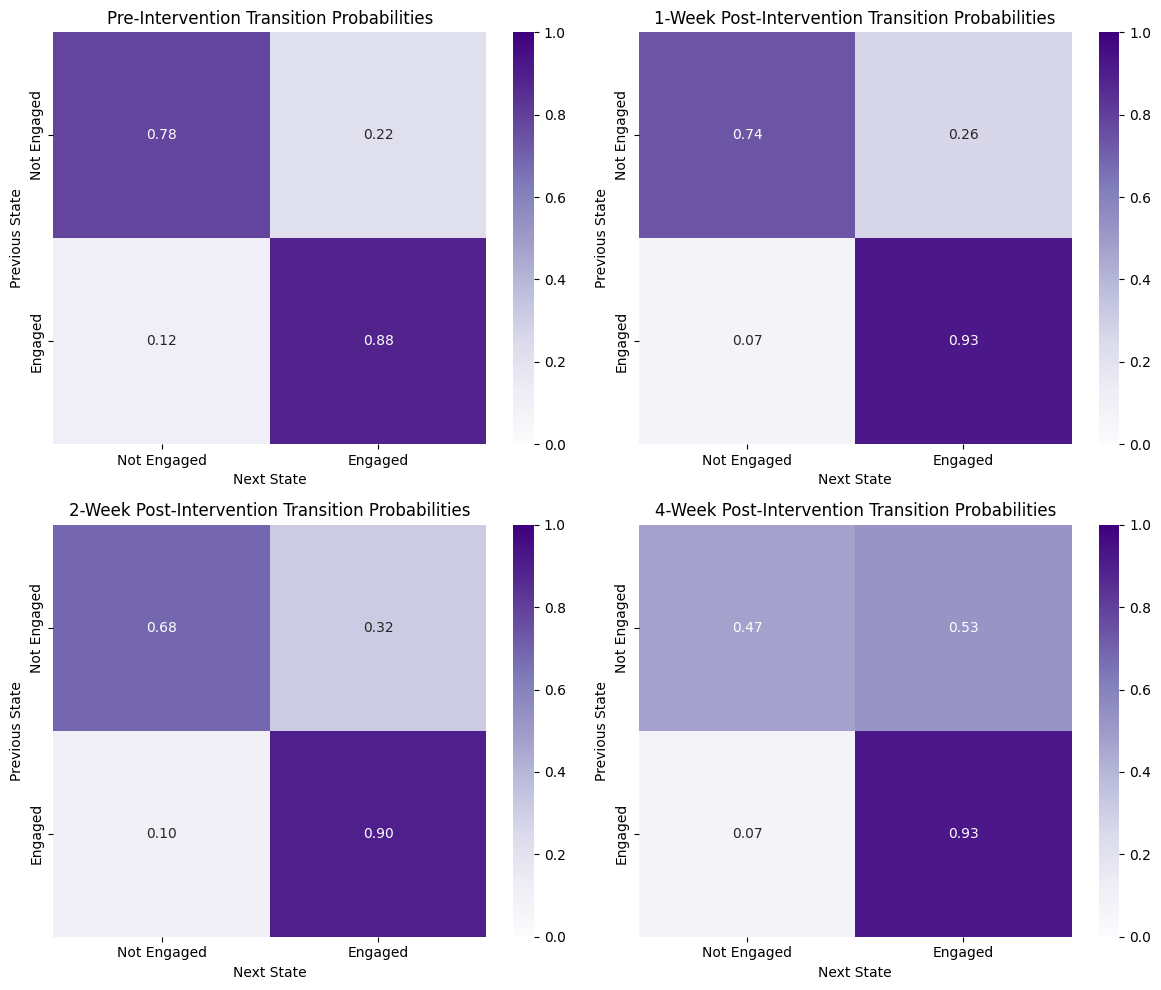

In [40]:
# Plot pre-intervention and multiple post-intervention time windows
time_windows = [1, 2, 4]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First subplot: Pre-intervention transitions
ax = axes[0, 0]
trans_matrix_pre = get_pre_intervention_transitions(states_array, interventions_array)
sns.heatmap(trans_matrix_pre, annot=True, cmap="Purples", fmt=".2f",
            xticklabels=state_labels, yticklabels=state_labels, ax=ax,
            vmin=0, vmax=1)
ax.set_title("Pre-Intervention Transition Probabilities")
ax.set_xlabel("Next State")
ax.set_ylabel("Previous State")

# Remaining subplots: Post-intervention n-step transitions
for plot_idx, n_steps in enumerate(time_windows):
    row_idx = (plot_idx + 1) // 2
    col_idx = (plot_idx + 1) % 2
    ax = axes[row_idx, col_idx]
    trans_matrix = get_n_step_transitions(states_array, interventions_array, n_steps)
    sns.heatmap(trans_matrix, annot=True, cmap="Purples", fmt=".2f",
                xticklabels=state_labels, yticklabels=state_labels, ax=ax,
                vmin=0, vmax=1)
    ax.set_title(f"{n_steps}-Week Post-Intervention Transition Probabilities")
    ax.set_xlabel("Next State")
    ax.set_ylabel("Previous State")

plt.tight_layout()
plt.show()

##### for aggregations

In [41]:
def get_n_step_predicted_transitions(y_preds, n_preds, n_steps, threshold=0.5):
    """Calculate n-step transition matrices"""
    y_states = np.array([np.array(timestep) > threshold for timestep in y_preds])
    n_states = np.array([np.array(timestep) > threshold for timestep in n_preds])
    
    y_transitions = np.zeros((2, 2))
    n_transitions = np.zeros((2, 2))
    
    for t in range(len(y_preds)-n_steps):
        for i in range(len(y_states[t])):
            y_prev = int(y_states[t][i])
            y_next = int(y_states[t+n_steps][i])
            y_transitions[y_prev, y_next] += 1
            
            n_prev = int(n_states[t][i])
            n_next = int(n_states[t+n_steps][i])
            n_transitions[n_prev, n_next] += 1
    
    # Normalize
    for transitions in [y_transitions, n_transitions]:
        row_sums = transitions.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        transitions /= row_sums
    
    return y_transitions, n_transitions

def plot_combined_transitions(method_preds, method_name, time_windows=[1,2,4]):
    """Plot compact visualization of transitions over multiple time windows"""
    y_preds, n_preds = method_preds
    
    fig, axes = plt.subplots(2, len(time_windows), figsize=(4*len(time_windows), 8))
    
    for i, weeks in enumerate(time_windows):
        y_trans, n_trans = get_n_step_predicted_transitions(y_preds, n_preds, weeks)
        
        # No intervention
        sns.heatmap(n_trans, annot=True, cmap="Purples", fmt=".2f",
                    xticklabels=state_labels, yticklabels=state_labels, 
                    ax=axes[0,i], vmin=0, vmax=1)
        axes[0,i].set_title(f"{weeks}-Week Ahead\nNo Intervention")
        
        # Intervention
        sns.heatmap(y_trans, annot=True, cmap="Purples", fmt=".2f",
                    xticklabels=state_labels, yticklabels=state_labels,
                    ax=axes[1,i], vmin=0, vmax=1)
        axes[1,i].set_title(f"{weeks}-Week Ahead\nWith Intervention")
    
    fig.suptitle(f"Transition Probabilities: {method_name}", y=1.02)
    plt.tight_layout()
    return fig

# Plot for each method
for method_name, preds in methods.items():
    fig = plot_combined_transitions(preds, method_name)
    plt.show()

NameError: name 'methods' is not defined

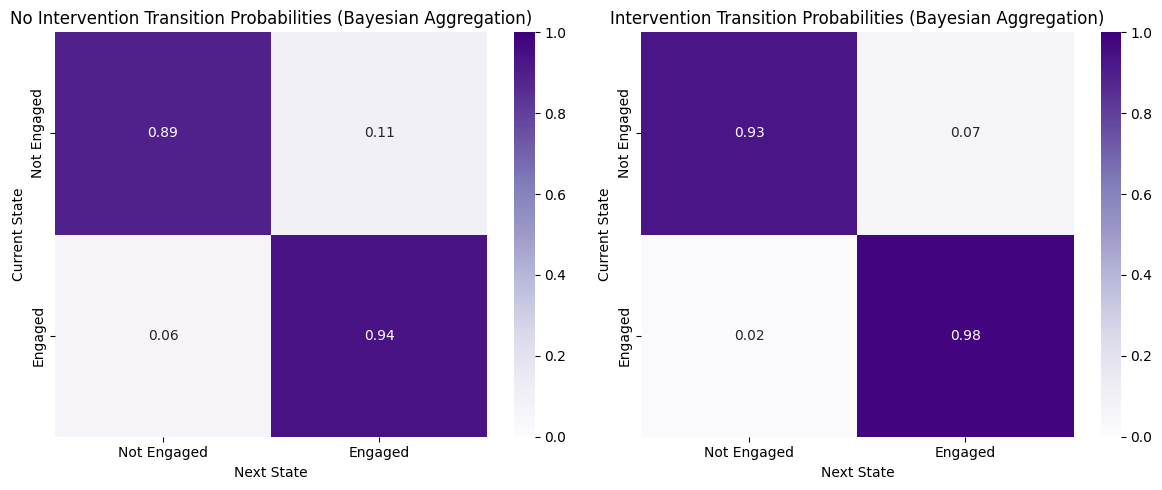

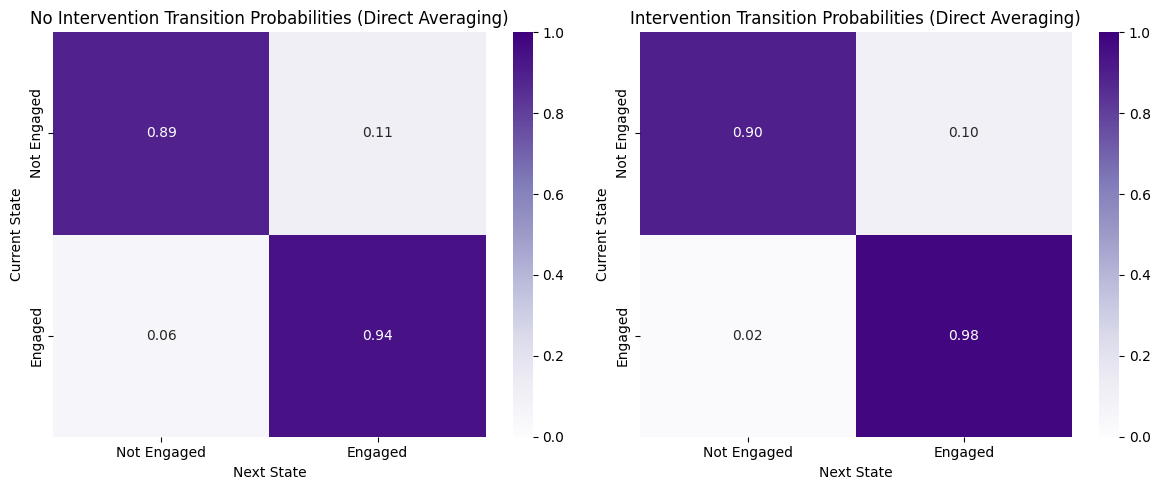

In [42]:
def get_predicted_transitions(y_preds, n_preds, threshold=0.5):
    """
    Calculate transition matrices from predicted probabilities
    y_preds: predictions with intervention
    n_preds: predictions without intervention
    threshold: threshold for converting probabilities to binary states
    """
    # Convert probabilities to binary states using threshold
    y_states = np.array([np.array(timestep) > threshold for timestep in y_preds])
    n_states = np.array([np.array(timestep) > threshold for timestep in n_preds])
    
    # Calculate transitions for both scenarios
    y_transitions = np.zeros((2, 2))
    n_transitions = np.zeros((2, 2))
    
    # For each timestep except the last
    for t in range(len(y_preds)-1):
        # Intervention case
        for i in range(len(y_states[t])):
            prev_state = int(y_states[t][i])
            next_state = int(y_states[t+1][i])
            y_transitions[prev_state, next_state] += 1
            
        # No intervention case
        for i in range(len(n_states[t])):
            prev_state = int(n_states[t][i])
            next_state = int(n_states[t+1][i])
            n_transitions[prev_state, next_state] += 1
    
    # Normalize
    y_row_sums = y_transitions.sum(axis=1, keepdims=True)
    n_row_sums = n_transitions.sum(axis=1, keepdims=True)
    
    # Avoid division by zero
    y_row_sums[y_row_sums == 0] = 1
    n_row_sums[n_row_sums == 0] = 1
    
    return y_transitions/y_row_sums, n_transitions/n_row_sums


def plot_predicted_transition_matrices(y_preds, n_preds, method_name, threshold=0.5):
    """
    Plot transition matrices for predicted states
    """
    y_trans, n_trans = get_predicted_transitions(y_preds, n_preds, threshold)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot no-intervention transitions
    sns.heatmap(n_trans, annot=True, cmap="Purples", fmt=".2f",
                xticklabels=state_labels, yticklabels=state_labels, ax=ax1,
                vmin=0, vmax=1)
    ax1.set_title(f"No Intervention Transition Probabilities ({method_name})")
    ax1.set_xlabel("Next State")
    ax1.set_ylabel("Current State")
    
    # Plot intervention transitions
    sns.heatmap(y_trans, annot=True, cmap="Purples", fmt=".2f",
                xticklabels=state_labels, yticklabels=state_labels, ax=ax2,
                vmin=0, vmax=1)
    ax2.set_title(f"Intervention Transition Probabilities ({method_name})")
    ax2.set_xlabel("Next State")
    ax2.set_ylabel("Current State")
    
    plt.tight_layout()
    return fig

# Plot transitions for each prediction method
methods = {
    'Bayesian Aggregation': (yP_combined, nP_combined),
    'Direct Averaging': (yP_direct_avg, nP_direct_avg),
    # 'Lowest Uncertainty': (yP_lowest_unc, nP_lowest_unc)
}

# Create plots for each method
for method_name, (y_preds, n_preds) in methods.items():
    fig = plot_predicted_transition_matrices(y_preds, n_preds, method_name)
    plt.show()

In [43]:
def plot_state_stability(y_preds, n_preds, method_name, threshold=0.5):
    # Convert to binary states
    y_states = np.array([np.array(timestep) > threshold for timestep in y_preds])
    n_states = np.array([np.array(timestep) > threshold for timestep in n_preds])
    
    # Calculate proportion maintaining same state
    y_stability = []
    n_stability = []
    
    for t in range(len(y_states)-1):
        y_same = (y_states[t] == y_states[t+1]).mean()
        n_same = (n_states[t] == n_states[t+1]).mean()
        y_stability.append(y_same)
        n_stability.append(n_same)
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_stability, label='With Intervention', marker='o')
    plt.plot(n_stability, label='No Intervention', marker='o')
    plt.xlabel('Week')
    plt.ylabel('Proportion Maintaining State')
    plt.title(f'State Stability Over Time ({method_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_state_distributions(y_preds, n_preds, method_name, threshold=0.5):
    y_states = np.array([np.array(timestep) > threshold for timestep in y_preds])
    n_states = np.array([np.array(timestep) > threshold for timestep in n_preds])
    
    y_engaged = y_states.mean(axis=1)
    n_engaged = n_states.mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_engaged, label='With Intervention', marker='o')
    plt.plot(n_engaged, label='No Intervention', marker='o')
    plt.xlabel('Week')
    plt.ylabel('Proportion Engaged')
    plt.title(f'Engagement Evolution ({method_name})')
    plt.legend()
    plt.grid(True)

def plot_intervention_impact(y_preds, n_preds, method_name, threshold=0.5):
    y_states = np.array([np.array(timestep) > threshold for timestep in y_preds])
    n_states = np.array([np.array(timestep) > threshold for timestep in n_preds])
    
    impact = y_states.mean(axis=1) - n_states.mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(impact)), impact)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Week')
    plt.ylabel('Difference in Engagement (Intervention - No Intervention)')
    plt.title(f'Intervention Impact Over Time ({method_name})')
    plt.grid(True)

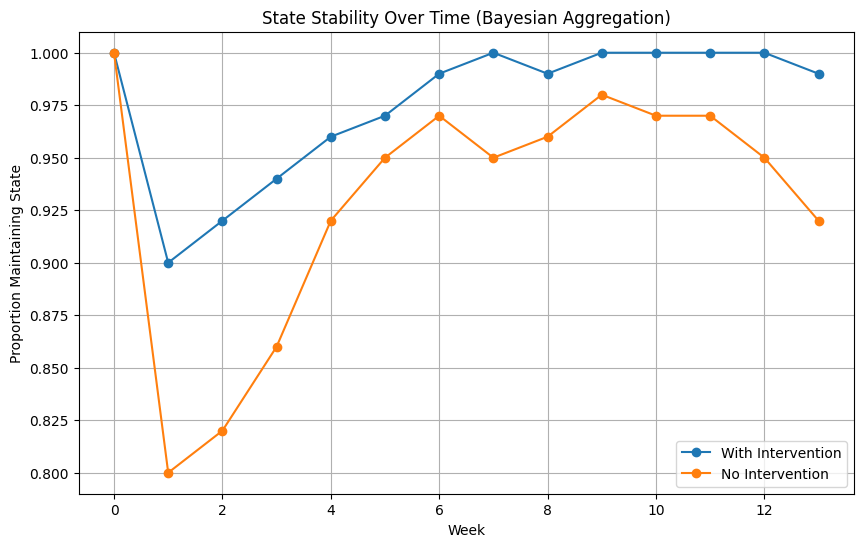

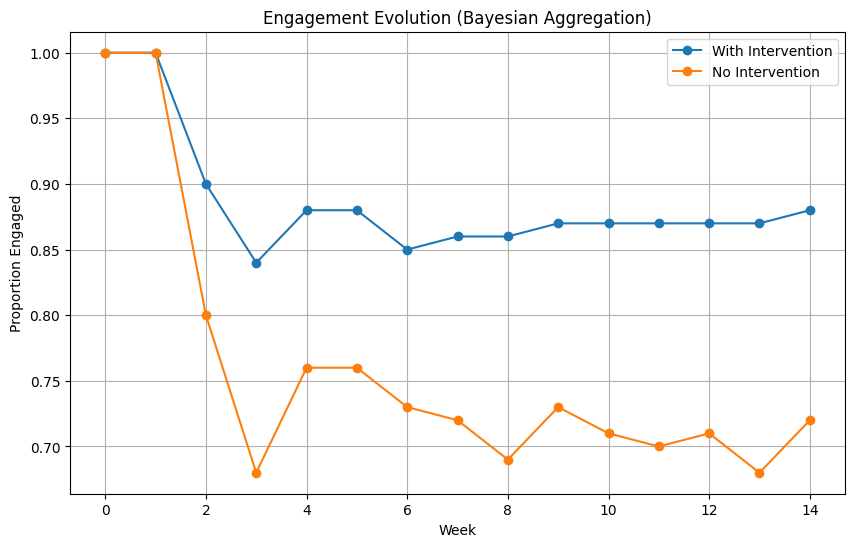

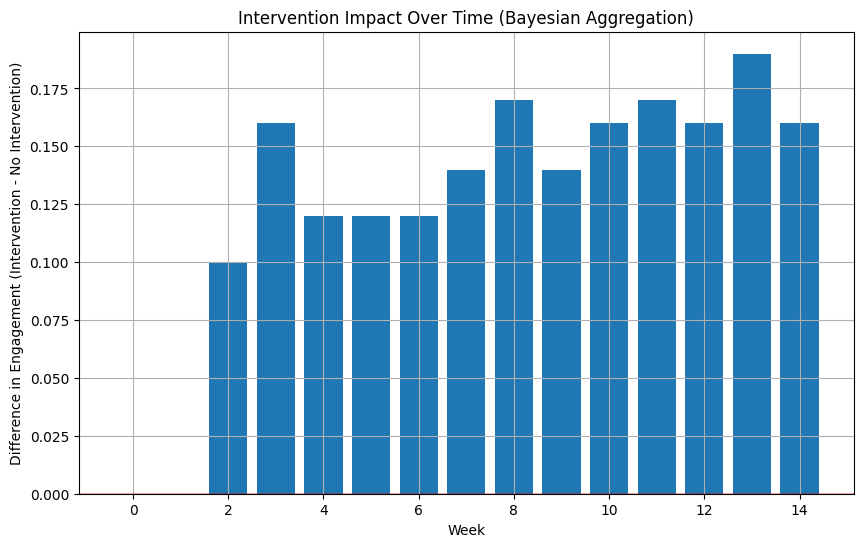

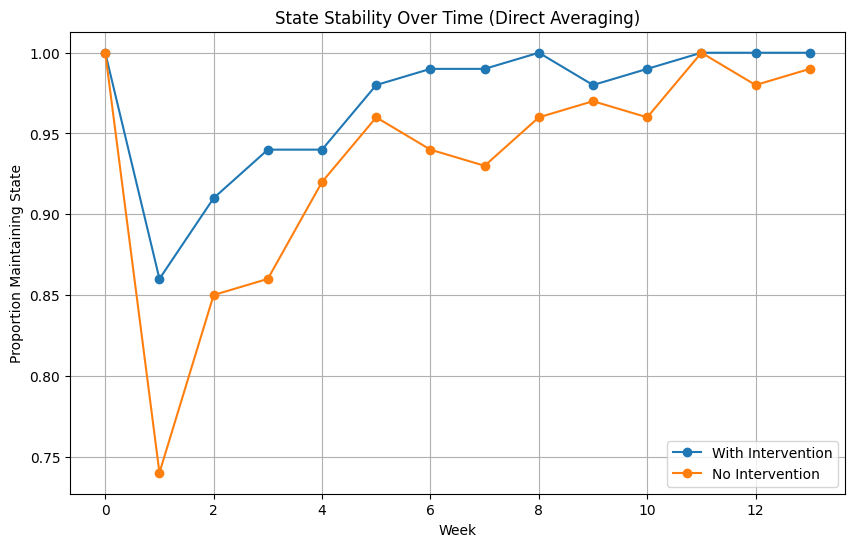

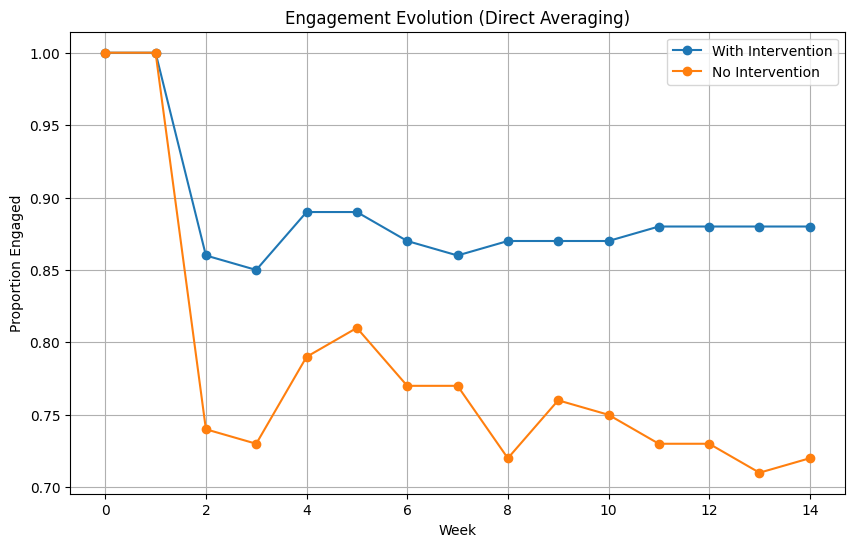

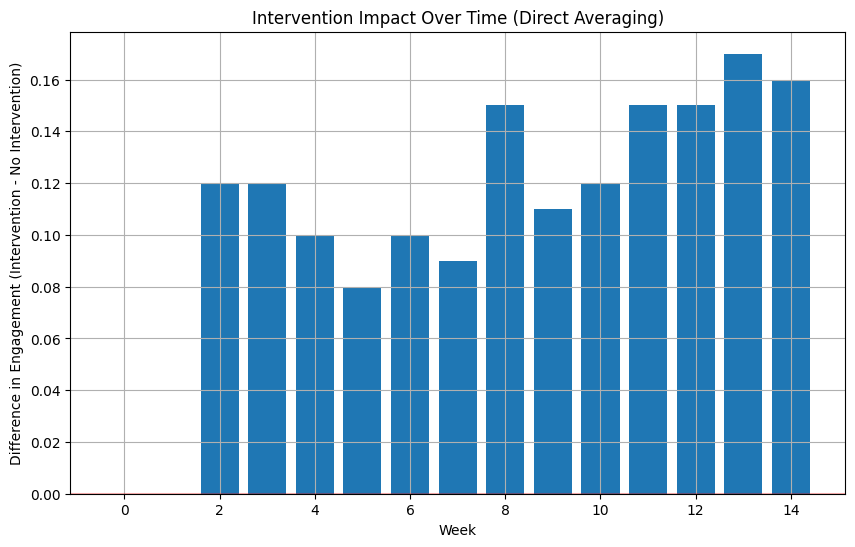

In [44]:
for method_name, (y_preds, n_preds) in methods.items():
    plot_state_stability(y_preds, n_preds, method_name)
    plot_state_distributions(y_preds, n_preds, method_name)
    plot_intervention_impact(y_preds, n_preds, method_name)
    plt.show()

In [45]:
def analyze_stratified_effects(y_preds, n_preds, features_array, threshold=0.5):
    """Analyze intervention effects stratified by features"""
    # Get complete samples that exist across all timesteps
    num_samples = len(features_array)
    
    y_states = np.array([np.array(timestep) > threshold for timestep in y_preds])
    n_states = np.array([np.array(timestep) > threshold for timestep in n_preds])
    
    feature_analyses = {
        'Age': (slice(7,12), ["<20", "20-24", "25-29", "30-34", "35+"]),
        'Education': (slice(16,23), ["1-5", "6-9", "10 Pass", "12 Pass", "Graduate", "Post Graduate", "Illiterate"]),
        'Language': (slice(12,16), ["Hindi", "Marathi", "Kannada", "Gujarati"]),
        'Phone': (slice(23,26), ["woman", "husband", "family"])
    }
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (feature_name, (feature_slice, categories)) in enumerate(feature_analyses.items()):
        feature_impact = []
        
        for cat_idx, category in enumerate(categories):
            category_indices = np.where(features_array[:, feature_slice][:, cat_idx] == 1)[0]
            
            if len(category_indices) > 0:
                y_engagement = np.mean([timestep[:num_samples][category_indices].mean() for timestep in y_states])
                n_engagement = np.mean([timestep[:num_samples][category_indices].mean() for timestep in n_states])
                impact = y_engagement - n_engagement
                feature_impact.append((category, impact, len(category_indices)))
        
        # Plotting
        if feature_impact:
            categories, effects, counts = zip(*feature_impact)
            ax = axes[idx]
            bars = ax.bar(categories, effects)
            ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
            
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'n={count}', ha='center', va='bottom')
            
            ax.set_title(f'Intervention Impact by {feature_name}')
            ax.set_ylabel('Impact')
            plt.setp(ax.get_xticklabels(), rotation=45)
        
        results[feature_name] = feature_impact
    
    plt.tight_layout()
    return results

# Usage
for method_name, (y_preds, n_preds) in methods.items():
    print(f"\nAnalysis for {method_name}:")
    results = analyze_stratified_effects(y_preds, n_preds, features_array)
    plt.suptitle(method_name, y=1.02)
    plt.show()


Analysis for Bayesian Aggregation:


NameError: name 'features_array' is not defined

In [46]:
# Load predictions and ground truths
# all_individual_preds : all 25 predictions for each arm and timestep [[],[],[],[],[]]
all_individual_preds, new_ground_truths = load_predictions_and_ground_truths(
    f"results/actions/openai_{num_arms}/all_individual_predictions_t1_{t1}_t2_{t2}.json", 
    f"results/actions/openai_{num_arms}/ground_truths_t1_{t1}_t2_{t2}_week_{t2-1}.json"
)

print(len(new_individual_preds), len(new_individual_preds[0]), len(new_individual_preds[0][0]))

all_individual_preds = np.reshape(all_individual_preds, (t2, num_acted, 5, 5))
new_ground_truths = np.squeeze(new_ground_truths)

print(len(all_individual_preds), len(all_individual_preds[0]), len(all_individual_preds[0][0]), len(all_individual_preds[0][0][0]))

# Loop over timesteps and arms, get actual final predictions for each in both scenarios
y_final_preds_all_time, n_final_preds_all_time = [], []
for t in range(t2):
    y_final_preds_all_arms, n_final_preds_all_arms = [], []

    for arm in range(num_acted):
        y_prompts_runs = all_individual_preds[t][arm] # 5 * 5

        y_mean_predictions_per_prompt = np.mean(y_prompts_runs, axis=1)

        y_final_mean_prediction = np.mean(y_mean_predictions_per_prompt) 

        y_final_preds_all_arms.append(y_final_mean_prediction)

    y_final_preds_all_time.append(y_final_preds_all_arms)

# Calculate uncertainties for y case (intervention)
timestep_ind_preds = restructure_predictions(all_individual_preds)
for time_mat in timestep_ind_preds:
    epistemic_uncertainty, _, _ = compute_uncertainties_from_llm_predictions(time_mat) 
    epistemic_uncertainty = np.squeeze(epistemic_uncertainty)
    model_data["y_epistemic_uncertainty"].append(epistemic_uncertainty)


# Loop over timesteps for accuracy and aggregation calcs
for t in range(t2):  
    y_preds_at_t = [y_final_preds_all_time[t][arm] for arm in range(num_acted)]  
    model_data["y_mean_predictions"].append(y_preds_at_t)


y_results_for_aggregation, n_results_for_aggregation = {}, {}
y_uncertainties_for_aggregation, n_uncertainties_for_aggregation = {}, {}

for i, (result, uncertainty) in enumerate(zip(model_data["y_mean_predictions"], model_data["y_epistemic_uncertainty"])):
    y_results_for_aggregation.setdefault(i, []).append(result)
    y_uncertainties_for_aggregation.setdefault(i, []).append(uncertainty)


15 60 5


NameError: name 'num_acted' is not defined

In [47]:
model_results["openai"]["y_mean_predictions"][-1]

[0.64,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.64,
 0.6,
 0.6,
 0.64,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6799999999999999,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.64,
 0.6,
 0.64,
 0.64,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.64,
 0.6,
 0.6,
 0.64,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.64,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.64,
 0.6,
 0.6,
 0.6,
 0.6,
 1.0,
 0.36,
 1.0,
 1.0,
 0.04,
 1.0,
 1.0,
 0.6,
 0.24,
 1.0,
 1.0,
 1.0,
 0.9199999999999999,
 0.96,
 0.72,
 1.0,
 0.72,
 1.0,
 1.0,
 0.96,
 0.8400000000000001,
 0.8800000000000001,
 1.0,
 1.0,
 1.0,
 0.52,
 0.64,
 1.0,
 0.0,
 0.12,
 0.04,
 0.9199999999999999,
 0.04,
 1.0,
 0.04,
 0.12,
 0.2,
 0.0,
 1.0,
 0.96]

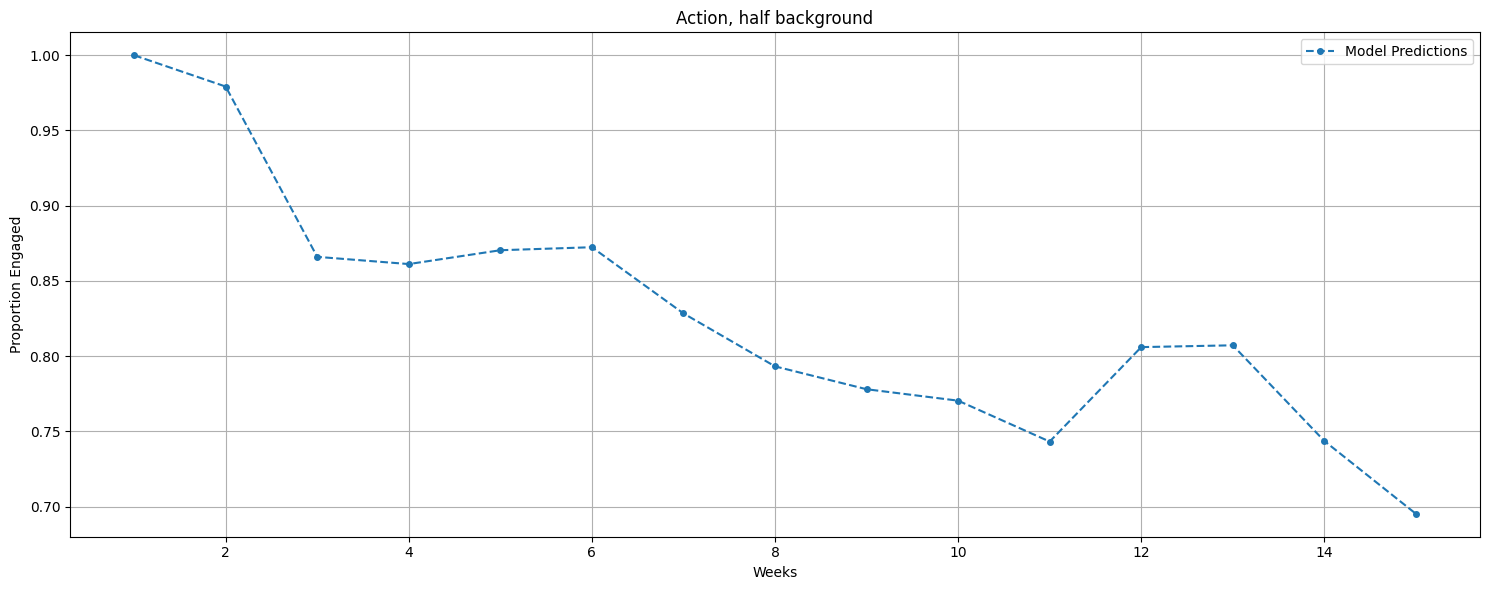

In [48]:
plt.figure(figsize=(15, 6))

# mean engagement per week
y_model_predictions = model_data["y_mean_predictions"]  # (num_time_steps, num_mothers)
y_mean_engagement_predictions = np.mean(np.array(y_model_predictions), axis=1)  # avg over all mothers

plt.plot(range(1, len(y_mean_engagement_predictions) + 1), y_mean_engagement_predictions, 
            marker="o", linestyle="--", markersize=4, label="Model Predictions")

plt.title("Action, half background")

plt.xlabel("Weeks")
plt.ylabel("Proportion Engaged")

plt.legend()
plt.grid(True)
plt.tight_layout()

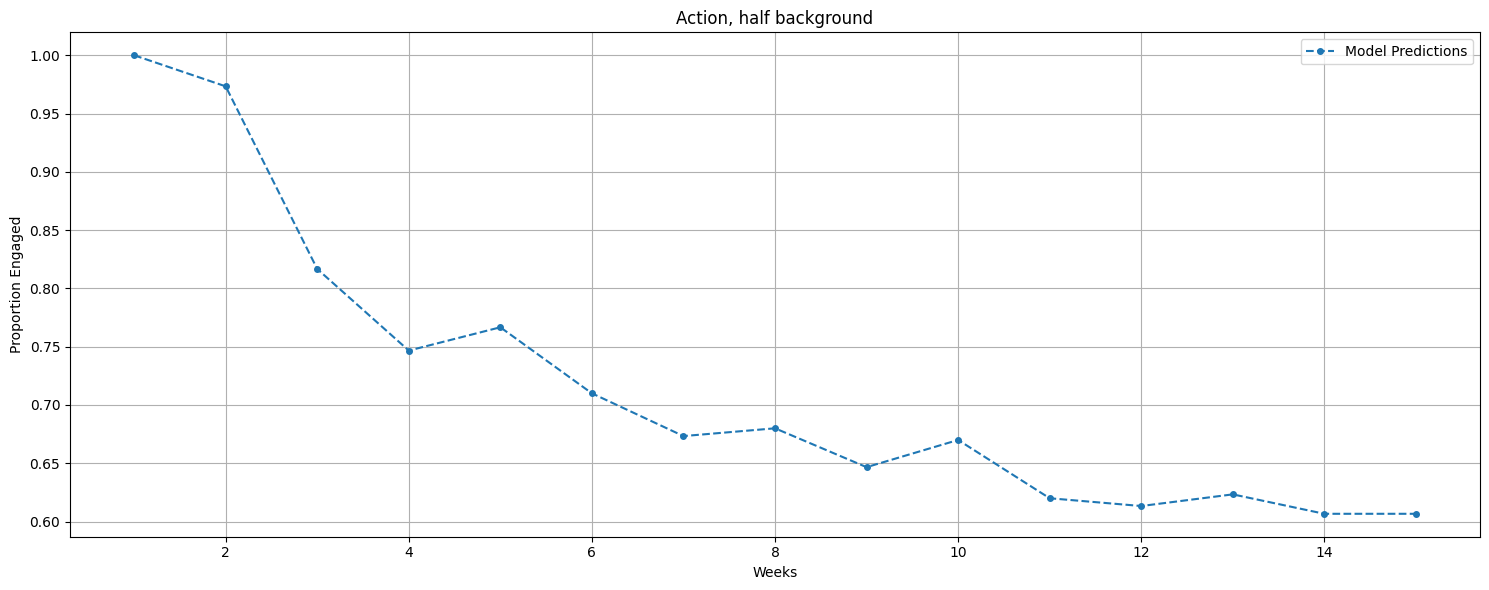

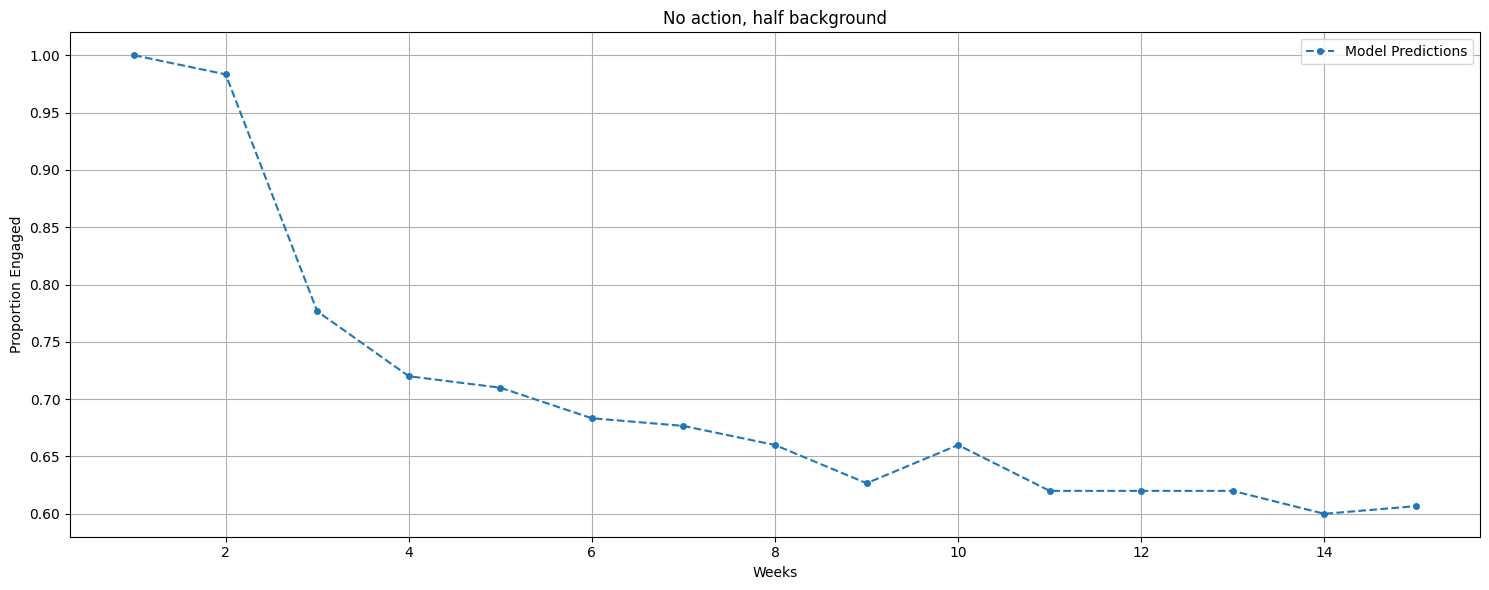

In [ ]:
plt.figure(figsize=(15, 6))

# mean engagement per week
y_model_predictions = model_data["y_mean_predictions"]  # (num_time_steps, num_mothers)
y_mean_engagement_predictions = np.mean(np.array(y_model_predictions), axis=1)  # avg over all mothers

plt.plot(range(1, len(y_mean_engagement_predictions) + 1), y_mean_engagement_predictions, 
            marker="o", linestyle="--", markersize=4, label="Model Predictions")

plt.title("No action, half background")

plt.xlabel("Weeks")
plt.ylabel("Proportion Engaged")

plt.legend()
plt.grid(True)
plt.tight_layout()

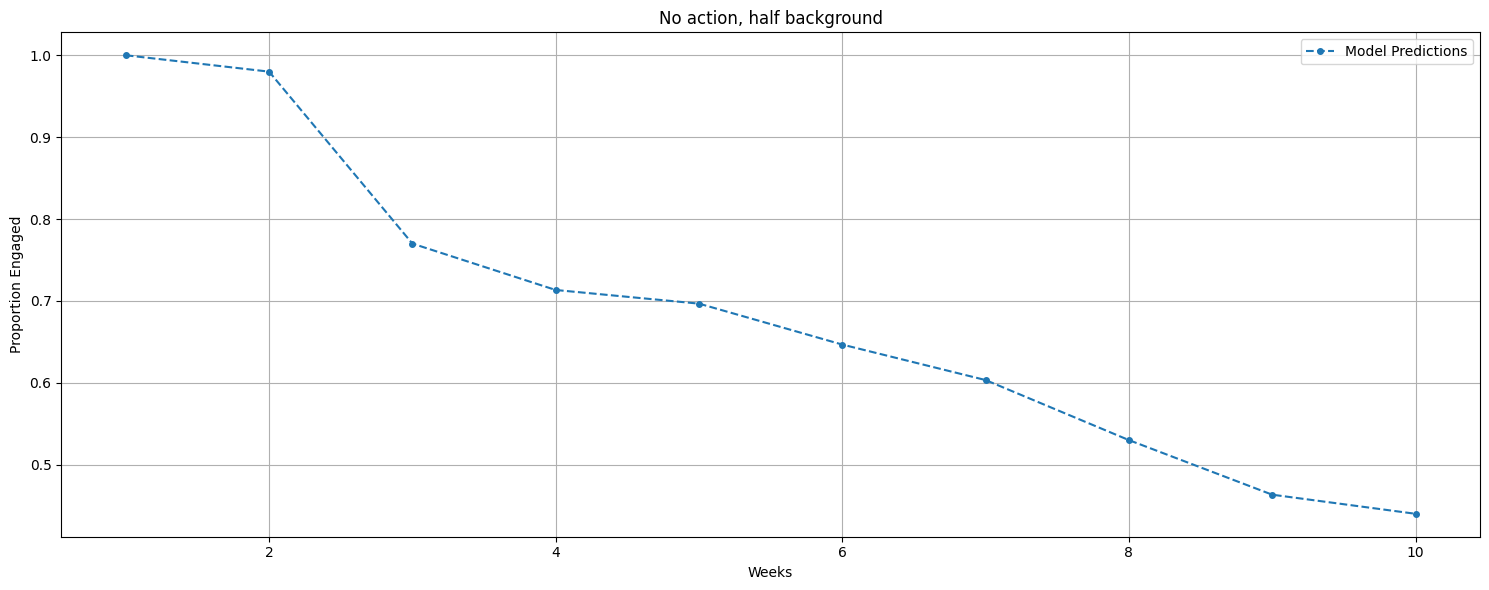

In [ ]:
## NO ACTION HALF BACKGROUND

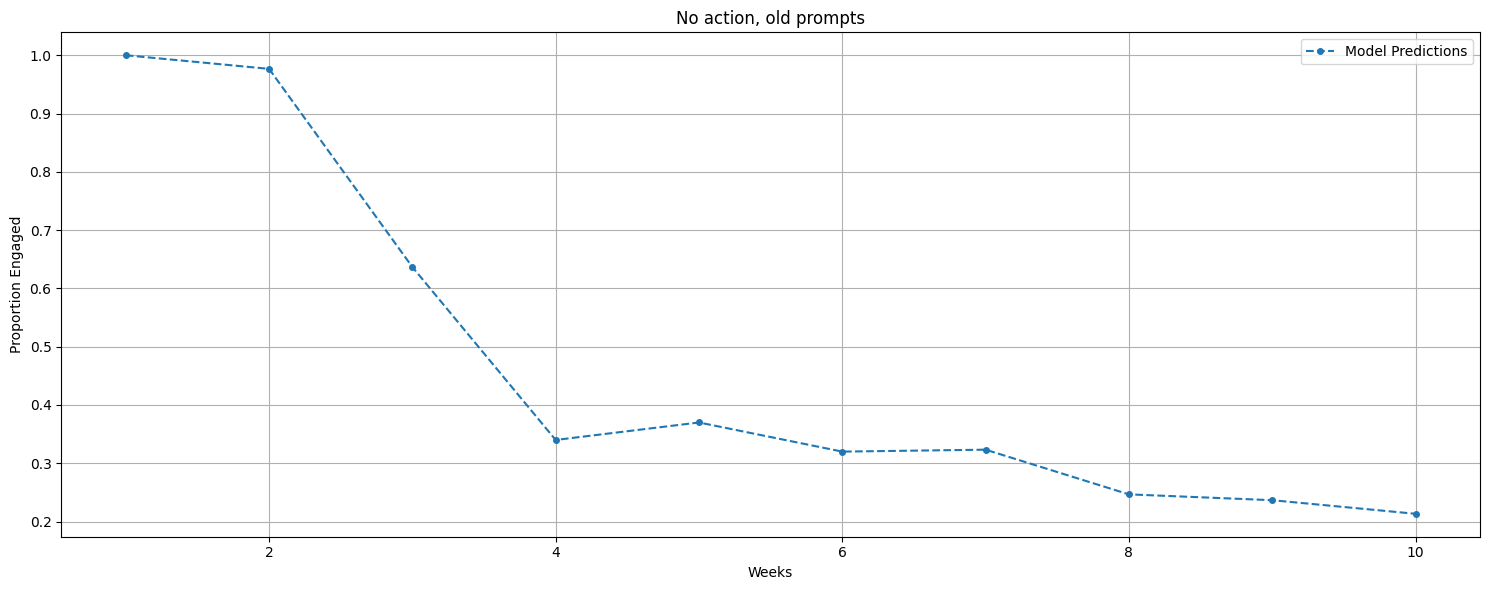

In [146]:
## NO ACTION OLD PROMPTS

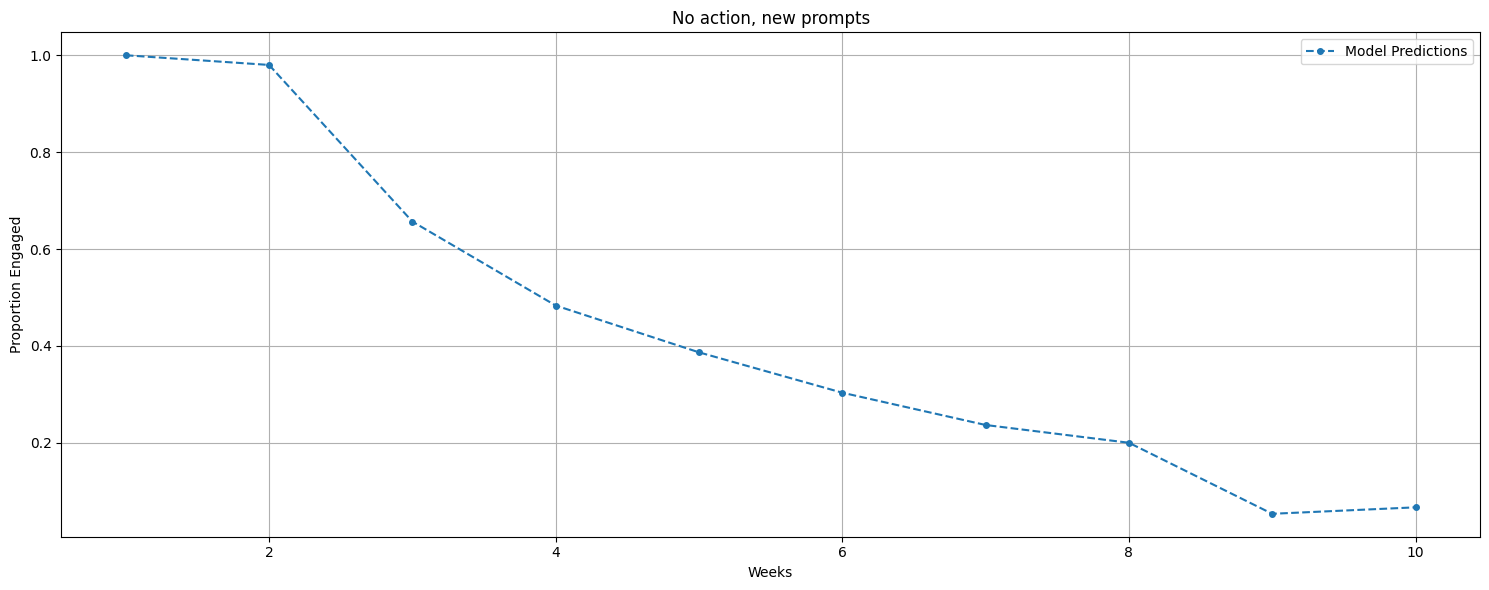

In [ ]:
## NO ACTION NEW PROMPTS

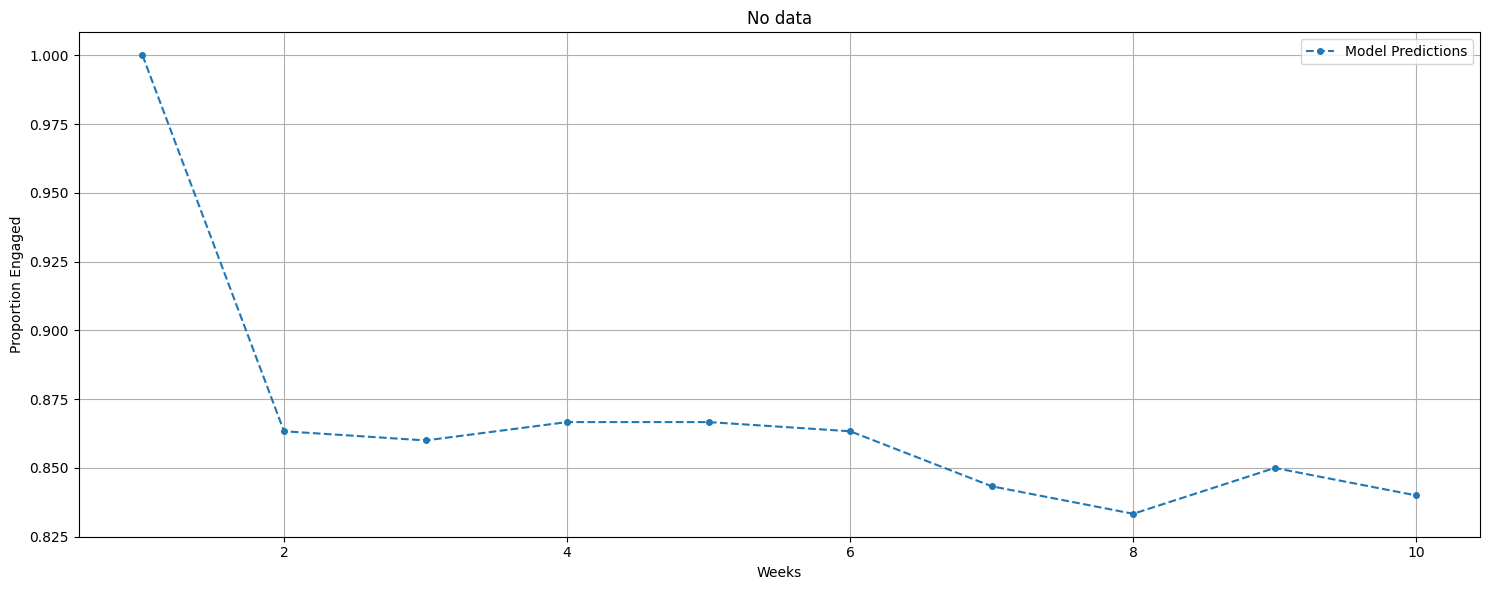

In [ ]:
## NO DATA

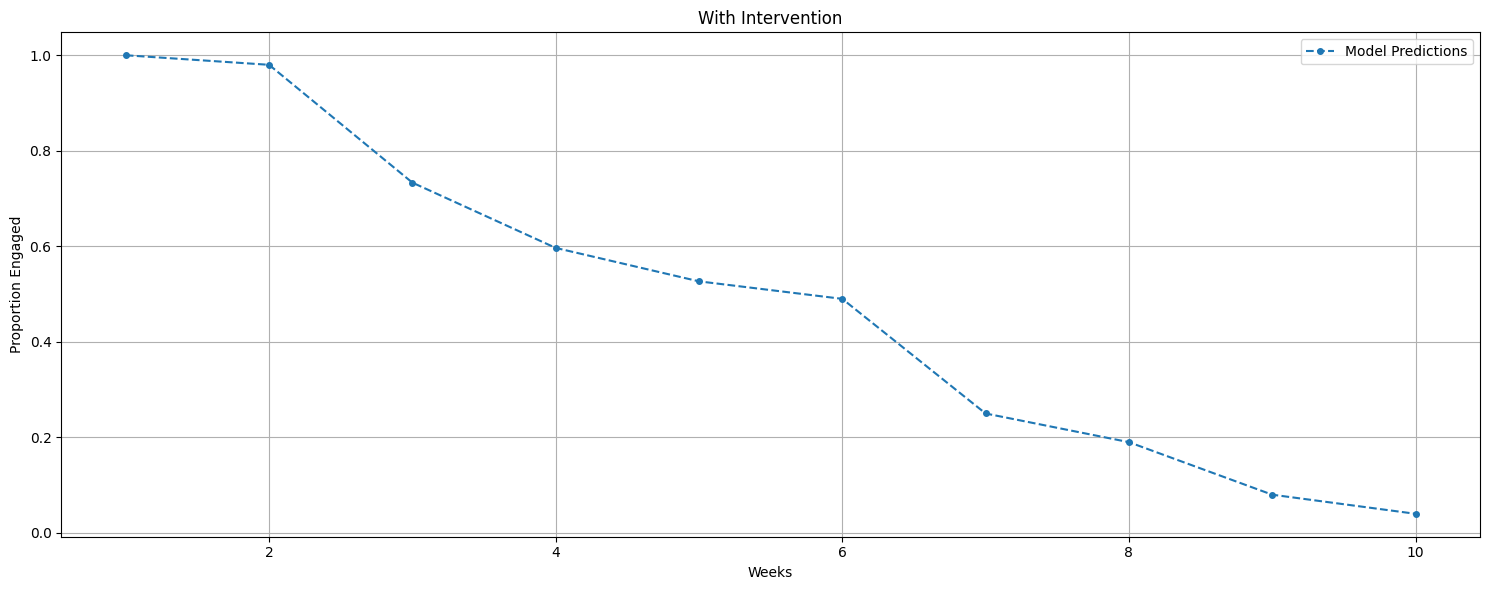

In [129]:
## DATA IN BIN NOT ACTION